A simple walkthrough of how to code a fully connected neural network
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.

Programmed by Aladdin Persson 
* 2020-04-08: Initial coding
* 2021-03-24: Added more detailed comments also removed part of
          check_accuracy which would only work specifically on MNIST.    
* 2021-05-24: Added single image display and verification - Prabhu
          Added more comments to understand
          Added one more hidden layer


https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/

In [1]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torchvision.datasets as dsets
import numpy as np
batch_size = 32
keep_prob = 1

Here we create our simple neural network. For more details here we are subclassing and
inheriting from nn.Module, this is the most general way to create your networks and
allows for more flexibility. I encourage you to also check out nn.Sequential which
would be easier to use in this scenario but I wanted to show you something that
"always" works.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

#Not used>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

class XNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__() #Override the init method
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))        
        x = (self.fc2(x))        
        x = (self.fc3(x))
        return x
       

In [4]:
class NN(torch.nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, num_classes, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out



x here is the mnist images and we run it through fc1, fc2, fc3 that we created above.
we also add a ReLU activation function in between and for that (since it has no parameters)
I recommend using nn.functional (F)

[Hyperlink to Datasets and Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

[Hyperlink to CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)


In [5]:


# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
input_size = 784  # 28 x 28
num_classes = 10  #output classification 0,1...9
learning_rate = 0.001
batch_size = 32 
test_size=32
num_epochs = 1
count = 0 # My  variable
tdata = []
tresult=[]
# Load Training and Test data
   # transforms.ToTensor convert image data 0-255 to Tensor data 0-1.0
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_size, shuffle=True)


# Initialize network
# .to(device) is to move / setup to cuda or cpu
#input_size is the input tensor *note this is image converted to one dimensional tensor.
#num_classes is the output classification 0 to 9 is 10 classes

#model = NN(input_size=input_size, num_classes=num_classes).to(device)
model = NN()
# The way the loss is to be computed
criterion = nn.CrossEntropyLoss()

# The way the Optim will work
#model.parameters() extracted from model

#optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    #batch_idx is index of each batch. # data, targets are extracted from train_loader
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # 1 Get data to cuda/cpu if possible
        #data = data.to(device=device)
        #targets = targets.to(device=device)
        X = Variable(data)    # image is already size of (28x28), no reshape
        Y = Variable(targets)    # label is not one-hot encoded

        # 2 convert image (square tensor 28 x 28) to linear tensor (1 x 784)
        #data = data.reshape(data.shape[0], -1)
        #print(data)
        optimizer.zero_grad() # <= initialization of the gradients
        # 3 forward pass
        scores = model(X)
        #print(scores)
        #print(targets)
        loss = criterion(scores, targets)
        #loss_func = torch.nn.CrossEntropyLoss() 
        #loss = loss_func(scores, targets.squeeze())
        #print (loss)
        # 4 backward
        #optimizer.zero_grad()
        loss.backward()
        
        # 5 gradient descent or adam step
        optimizer.step()

        


C:\Users\Vaishali\AppData\Local\Temp/ipykernel_2024/1612075814.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)
  0%|                                                 | 0/1875 [00:00<?, ?it/s]d:\users\vaishali\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████| 1875/1875 [01:52<00:00, 16.60it/s]


Extracting the data to single array - Prabhu

Displaying a single image and its classification by NN - Prabhu

In [4]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(test_dataset.data.view(len(test_dataset), 1, 28, 28).float())
Y_test = Variable(test_dataset.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 97.56 %


<ipython-input-5-48ef04c7b69a>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(4,4,i+1)


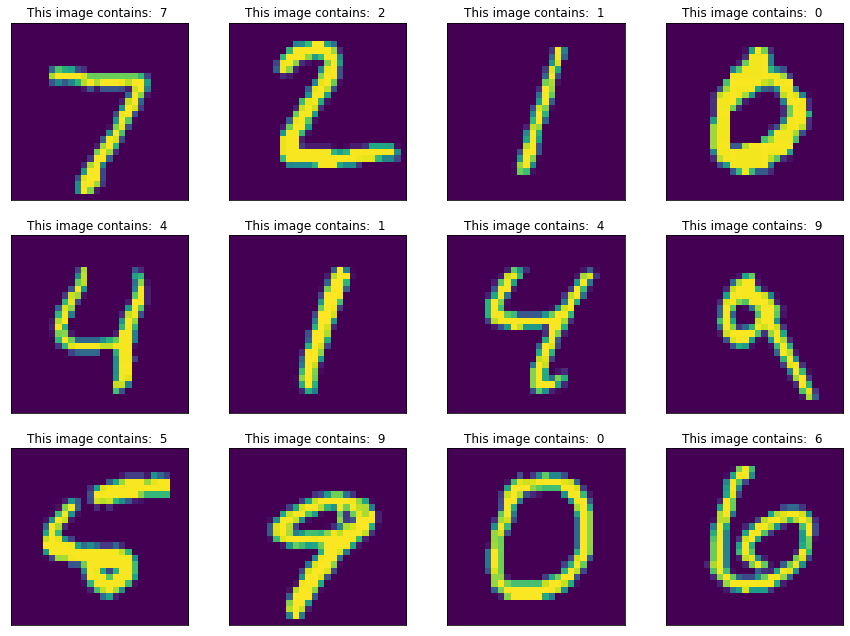

In [5]:
from matplotlib import pylab as plt

plt.figure(figsize=(15,15), facecolor='white')
for i in torch.arange(0,12):
  val, idx = torch.max(prediction, dim=1)
  plt.subplot(4,4,i+1)  
  plt.imshow(X_test[i][0])
  plt.title('This image contains: {0:>2} '.format(idx[i].item()))
  plt.xticks([]), plt.yticks([])
  plt.plt.subplots_adjust()




Now checking the accuracy using the data set
Check "9" at pos 4000 with 1 epoch and 2 epoch